## Project 2018 - "Programming For Data Analysis"

### A Notebook by: Marco Men

### Date Of Last Commit: 14th December 2018

## Introduction

In this notebook I will be choosing a  real-world phenomenon ( stock price fluctuations ) and strategy creation based on real data.
I will investigate the types of variables involved(their distributions and relationships with each other)
I will simulate/synthesise the dataset as closely matching their properties as possible.
I will also detail my research and implement the simulation in this Jupyter notebook

https://realpython.com/python-random/


# The Story For The Simulation

I believe every simulation should start with a story. The story is fictitious, so I had to use my imagination and creativity.

Let's say I work in a stock trading firm in the "quant" department. I was asked to come up with a predictor algorithm that provides trading signals, that after being tested could be implemented to provide "signals" for any trade.  

I will be measuring the performance of the market based on historical price information and use this information for backtesting purposes ( our strategies versus actual market performance )

First, I will be using Standard & Poor's 500 (S&P500), which is considered to be a good proxy for the whole stock market in the United States, due to the high number of names included in the index and the total market capitalisation represented by it.
It also has highly liquid futures and option markets.


In [1]:
# https://stackoverflow.com/questions/49705047/downloading-mutliple-stocks-at-once-from-yahoo-finance-python

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt

yf.pdr_override()




tickers = ['^GSPC']

start_date = '2000-01-01'
end_date = '2018-09-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
SP500 = pdr.get_data_yahoo(tickers,start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 downloaded


In [2]:
SP500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4716 entries, 2000-01-03 to 2018-09-28
Data columns (total 6 columns):
Open         4716 non-null float64
High         4716 non-null float64
Low          4716 non-null float64
Close        4716 non-null float64
Adj Close    4716 non-null float64
Volume       4716 non-null int32
dtypes: float64(5), int32(1)
memory usage: 239.5 KB


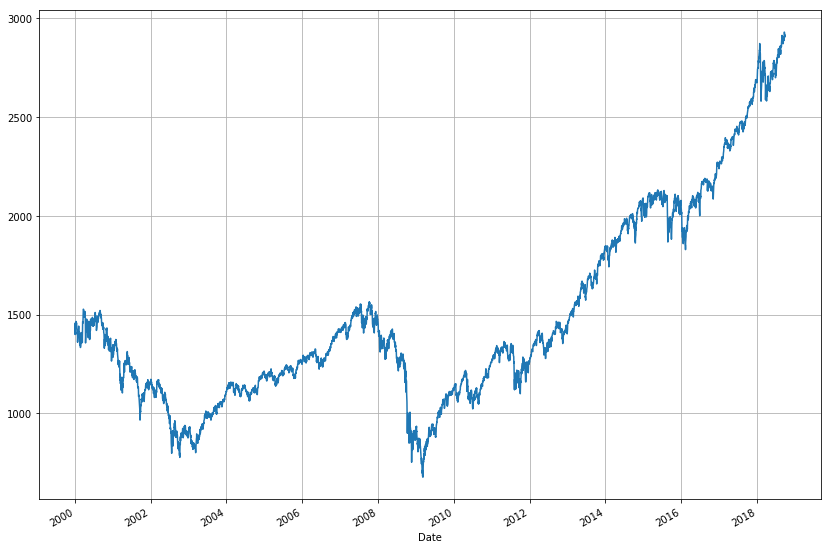

In [3]:
SP500['Close'].plot(grid=True, figsize=(14,10))


We want to implement a strategy based on both one-month(21 trading days) and six-months(126 trading days) trends. So, I will be calculating both moving averages.

In [4]:
# Moving Averages for 21 days and 126 days


SP500['21d'] = np.round(SP500['Close'].rolling(21).mean(), 2)
SP500['126d'] = np.round(SP500['Close'].rolling(126).mean(), 2)

The two extra columns created only start at those dates when 21 and 126 observation points ,respectively, are available for the first time to calculate their averages ( or means )

In [5]:
# I have created another two columns


SP500[['Close', '21d', '126d']].tail()

,Close,21d,126d
Date,,,
2018-09-24,2919.370117,2898.32,2767.73
2018-09-25,2915.560059,2900.26,2770.14
2018-09-26,2905.969971,2900.70,2772.53
2018-09-27,2914.000000,2901.49,2774.69
2018-09-28,2913.979980,2901.48,2777.33


Plotting the new data created above will provide some insights in terms of what happened in the past with regards to **upward** and **downward** trends.

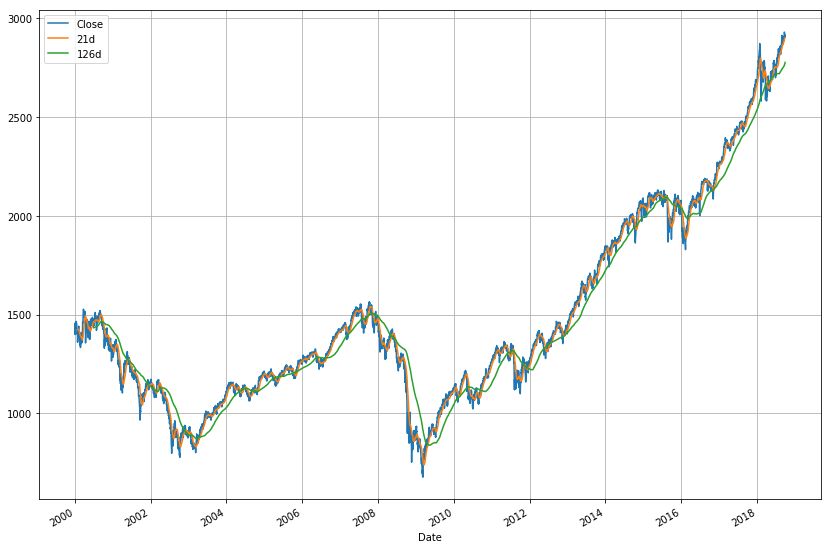

In [6]:
SP500[['Close', '21d', '126d']].plot(grid=True,figsize=(14,10))

To recap, the 'Close' is simply the actual historical stock prices of S&P500 index from the start of 2000 until the end of September 2018.

My strategy with the moving averages(21 days and 126 days) is then overlapped on the plot. And now we can devise a rule to generate trading signals:

* Buy signal ( go long )
    The 21d trend is for the first time *SD points above* 126d trend.
    
* Wait ( park in cash )
    The 21d trend is within a range of +/- *SD points around* the 126d trend.
    
* Sell signal ( go short )
    The 21d trend is for the first time *SD points below* the 126d trend 
    
Next, I need to add another column to the trend dataframe with the differences between the two trends ( 42d - 126d).



In [7]:
SP500['21-126'] = SP500['21d'] - SP500['126d']
SP500['21-126'].tail()

Date
2018-09-24    130.59
2018-09-25    130.12
2018-09-26    128.17
2018-09-27    126.80
2018-09-28    124.15
Name: 21-126, dtype: float64

The first number of rows ( 126 to be precise )in the dataframe will be assigned 'NaN' by pandas as the calculation of the statistics is only started to be calculated after the 21 and 126 observation points on the 'Close' column occurred ( As seen on the next code ). 

In [8]:
SP500['21-126'].head(126)

Date
2000-01-03      NaN
2000-01-04      NaN
2000-01-05      NaN
2000-01-06      NaN
2000-01-07      NaN
2000-01-10      NaN
2000-01-11      NaN
2000-01-12      NaN
2000-01-13      NaN
2000-01-14      NaN
2000-01-18      NaN
2000-01-19      NaN
2000-01-20      NaN
2000-01-21      NaN
2000-01-24      NaN
2000-01-25      NaN
2000-01-26      NaN
2000-01-27      NaN
2000-01-28      NaN
2000-01-31      NaN
2000-02-01      NaN
2000-02-02      NaN
2000-02-03      NaN
2000-02-04      NaN
2000-02-07      NaN
2000-02-08      NaN
2000-02-09      NaN
2000-02-10      NaN
2000-02-11      NaN
2000-02-14      NaN
              ...  
2000-05-19      NaN
2000-05-22      NaN
2000-05-23      NaN
2000-05-24      NaN
2000-05-25      NaN
2000-05-26      NaN
2000-05-30      NaN
2000-05-31      NaN
2000-06-01      NaN
2000-06-02      NaN
2000-06-05      NaN
2000-06-06      NaN
2000-06-07      NaN
2000-06-08      NaN
2000-06-09      NaN
2000-06-12      NaN
2000-06-13      NaN
2000-06-14      NaN
2000-06-15     

Let me make it more formal and generate another column called *regime*, where we will assume a value of 34 for the signal threshold.

In [9]:
SD = 34
SP500['Regime'] = np.where(SP500['21-126'] > SD, 1, 0)
SP500['Regime'] = np.where(SP500['21-126'] < -SD, -1, SP500['Regime'])
# for value counts
SP500['Regime'].value_counts()

 1    2144
 0    1754
-1     818
Name: Regime, dtype: int64

What the value counts ( above ) mean is that, on 2,144 trading dates, the 21d trend lies more than SD points ( 34 ) above the 126d trend. On 1,754 days, the 21d trend is more than SD points ( 34 ) below the 126d trend. Usually, if the short-term trend crosses the line of the log-term trend it tends to rest there for a while. This is the *regime* and can be represented as follows:

(-1.1, 1.1)

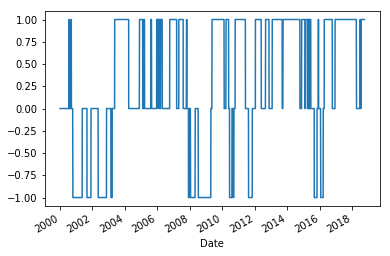

In [10]:
SP500['Regime'].plot(lw=1.5)
plt.ylim([-1.1,1.1])

Now I have everything ready to test the investment strategy based on the signals. For simplicity purposes, we will assume that an investor can directly invest in the index or can directly short the index, which in the real world must be accomplished by using index funds, exchange-traded funds, or futures on index. Such trades lead to transaction costs that are neglected here.
Based on our ***regime***, the *investor is either **long** or **short** in the market or parks his wealth in cash ( bears no interest )*.
The investor makes the market return when (s)he is **long**(1), make negative market returns when (s)he is **short**(-1), and makes no returns(0), when (s)he parks his/her wealth in cash.
I will need the market returns calculated for every single trading day to get the daily log returns.

In [11]:
SP500['Market'] = np.log(SP500['Close'] / SP500['Close'].shift(1))

To get the returns of the trend-based strategy, I just multiply the 'Regime' column, shifted by one day, by the 'Returns' columns ( the position is built "yesterday" and yields "today's" returns ).

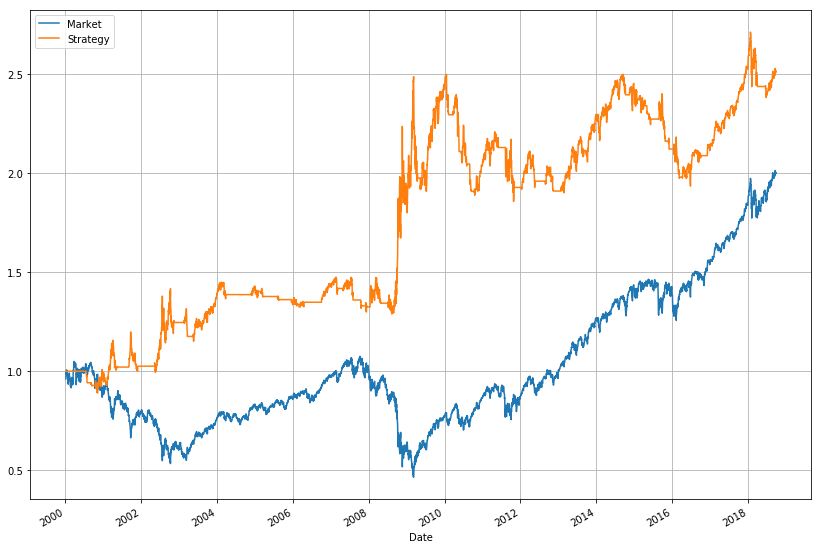

In [12]:
SP500['Strategy'] = SP500['Regime'].shift(1) * SP500['Market']

# And now for the plotting

SP500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True,figsize=(14,10))

The investor is able to lock in a much higher return over the relevant period than a plain long investment would provide. The plot above shows us a comparison between the cumulative continuous returns of the index against the cumulative continuous returns from our strategy.
During market downturns ( around 2003 and 2008/2009 ) the **shorting** of the market yields quite high returns. The strategy as a whole outperforms the market quite significantly.

Below I will be subsetting my DataFrame, which I will call 'simul_df' ( for simulation Data Frame). It will include the 'Close' column from SP500 and the synthesied data ('21d', '126d', '21-126', 'Regime','Market','Strategy')

In [36]:
# My fake dataset

simul_df = SP500[['Close','21d','126d','21-126','Regime','Market','Strategy']]

simul_df.info()

simul_df=simul_df.dropna() # This dataset only starts 126 days in the time series after because of NaNs dropped

simul_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4716 entries, 2000-01-03 to 2018-09-28
Data columns (total 7 columns):
Close       4716 non-null float64
21d         4696 non-null float64
126d        4591 non-null float64
21-126      4591 non-null float64
Regime      4716 non-null int32
Market      4715 non-null float64
Strategy    4715 non-null float64
dtypes: float64(6), int32(1)
memory usage: 276.3 KB


,Close,21d,126d,21-126,Regime,Market,Strategy
Date,,,,,,,
2000-06-30,1454.599976,1462.59,1433.30,29.29,0,0.008429,0.0
2000-07-03,1469.540039,1462.22,1433.41,28.81,0,0.010219,0.0
2000-07-05,1446.229980,1461.20,1433.78,27.42,0,-0.015989,-0.0
2000-07-06,1456.670044,1461.14,1434.22,26.92,0,0.007193,0.0
2000-07-07,1478.900024,1461.50,1434.81,26.69,0,0.015146,0.0


Next I will plot the density distribution for both Market and Strategy.

<Figure size 1008x720 with 0 Axes>

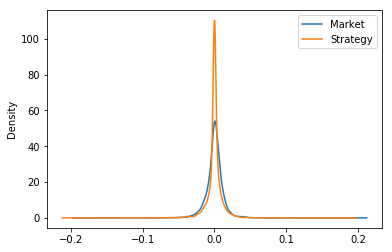

In [28]:
plt.figure(figsize=(14,10))
simul_df[['Market', 'Strategy']].plot.density()
plt.show()

Both are normally distributed and are approximated. With the strategy density plot showing a higher density peak.

<Figure size 1008x720 with 0 Axes>

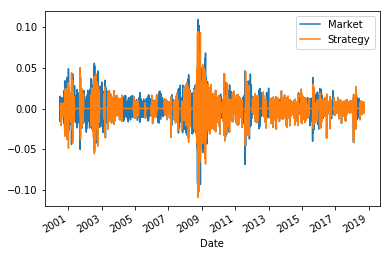

In [29]:
plt.figure(figsize=(14,10))
simul_df[['Market', 'Strategy']].plot()
plt.show()

The plot above shows 3 simulations of potential variations of Nissan closing prices
Mine PLC is the one company that presents the highest variance in terms of fluctuation of stock closing prices and then Sample PLC and the Original PLC plot is quite close to Nissan's data. This is made clear on the density graphs plotted above
With this simulation, I can see the possible variations that the stock price can have in the future under current conditions. Mine PLC would represent a market fluctuation with high of risk and uncertainty, Sample PLC with medium risk.